In [1]:
import numpy as np
import matplotlib.pyplot as plt    

In [2]:
def HWcall_MC(S0, V0, r, sigma, a, b, alpha, rho, T, K, n, M, red):
    dt = T / n
    discount_factor = np.exp(-r * T)
    if (red == 0):
        #variance reduction
        S1 = np.full(M, S0)
        S2 = np.full(M, S0)
        V1 = np.full(M, V0)
        V2 = np.full(M, V0)
        for i in range(1,n):
            WS = np.random.normal(0, 1, M)
            WV = np.random.normal(0, 1, M)
            dWS = np.sqrt(dt)*WS
            dWV = np.sqrt(dt)*(rho * WS + np.sqrt(1 - rho**2) * WV)

            S1 = S1 + S1 * r * dt + S1 * np.sqrt(V1) * dWS
            S2 = S2 + S2 * r * dt - S2 * np.sqrt(V2) * dWS
    
            V1 = np.maximum(V1 + a * (b - V1) * dt + sigma * np.power(V1, alpha) * dWV + 0.5 * sigma**2 * alpha * np.power(V1, 2*alpha-1) * (dWV**2  - dt),0)
            V2 = np.maximum(V2 + a * (b - V2) * dt - sigma * np.power(V2, alpha) * dWV + 0.5 * sigma**2 * alpha * np.power(V2, 2*alpha-1) * (dWV**2  - dt),0)
            
        payoff1 = np.maximum(S1 - K, 0)
        payoff2 = np.maximum(S2 - K, 0)

    # Combine payoffs from original and antithetic variates
        call_payoffs = (payoff1 + payoff2)/2
        call_price = discount_factor * np.mean(call_payoffs)
        a_M = call_price
        b_M = np.sqrt(np.sum((np.exp(-r * T)*(payoff1+payoff2)/2-a_M)**2)/(M-1))
        confidence_interval_down = a_M - 1.96*b_M/np.sqrt(M)
        confidence_interval_up = a_M + 1.96*b_M/np.sqrt(M)
        return call_price, confidence_interval_down, confidence_interval_up
    else:
        #without variance reduction
        S1 = np.full(M, S0)
        V1 = np.full(M, V0)
        for i in range(1,n):
            WS = np.random.normal(0, 1, M)
            WV = np.random.normal(0, 1, M)
            dWS = np.sqrt(dt)*WS
            dWV = np.sqrt(dt)*(rho * WS + np.sqrt(1 - rho**2) * WV)

            S1 = S1 + S1 * r * dt + S1 * np.sqrt(V1) * dWS
            
            V1 = np.maximum(V1 + a * (b - V1) * dt + sigma * np.power(V1, alpha) * dWV + 0.5 * sigma**2 * alpha * np.power(V1, 2*alpha-1) * (dWV**2  - dt),0)
    
        payoff1 = np.maximum(S1 - K, 0)
        call_price = discount_factor * np.mean(payoff1)
        a_M = call_price
        b_M = np.sqrt(np.sum((np.exp(-r * T)*payoff1-a_M)**2)/(M-1))
        confidence_interval_down = a_M - 1.96*b_M/np.sqrt(M)
        confidence_interval_up = a_M + 1.96*b_M/np.sqrt(M)
        return call_price, confidence_interval_down, confidence_interval_up

In [3]:
def download_inputs(file_path):
    inputs = {}
    with open(file_path, 'r') as file:
        for line in file:
            key, value = line.split('=')
            inputs[key.strip()] = float(value)
            
    call_price, confidence_interval_down, confidence_interval_up = HWcall_MC(
        S0=inputs['S0'], 
        V0=inputs['V0'],
        r=inputs['r'], 
        sigma=inputs['sigma'], 
        a=inputs['a'], 
        b=inputs['b'], 
        alpha=inputs['alpha'],
        rho=inputs['rho'],
        T=inputs['T'], 
        K=inputs['K'], 
        n=int(inputs['n']), 
        M=int(inputs['M']),
        red = 0
    )
    print("Option price:", call_price)
    print("Confidence interval: (", confidence_interval_down,",", confidence_interval_up,")")

In [4]:
download_inputs("cp3_data.txt")

Option price: 11.46666740425882
Confidence interval: ( 11.439347736195995 , 11.493987072321644 )


In [5]:
def read_inputs(file_path):
    params = {}
    with open(file_path, 'r') as file:
        for line in file:
            key, value = line.split('=')
            params[key.strip()] = float(value)
    return params
inputs = read_inputs("cp3_data.txt")

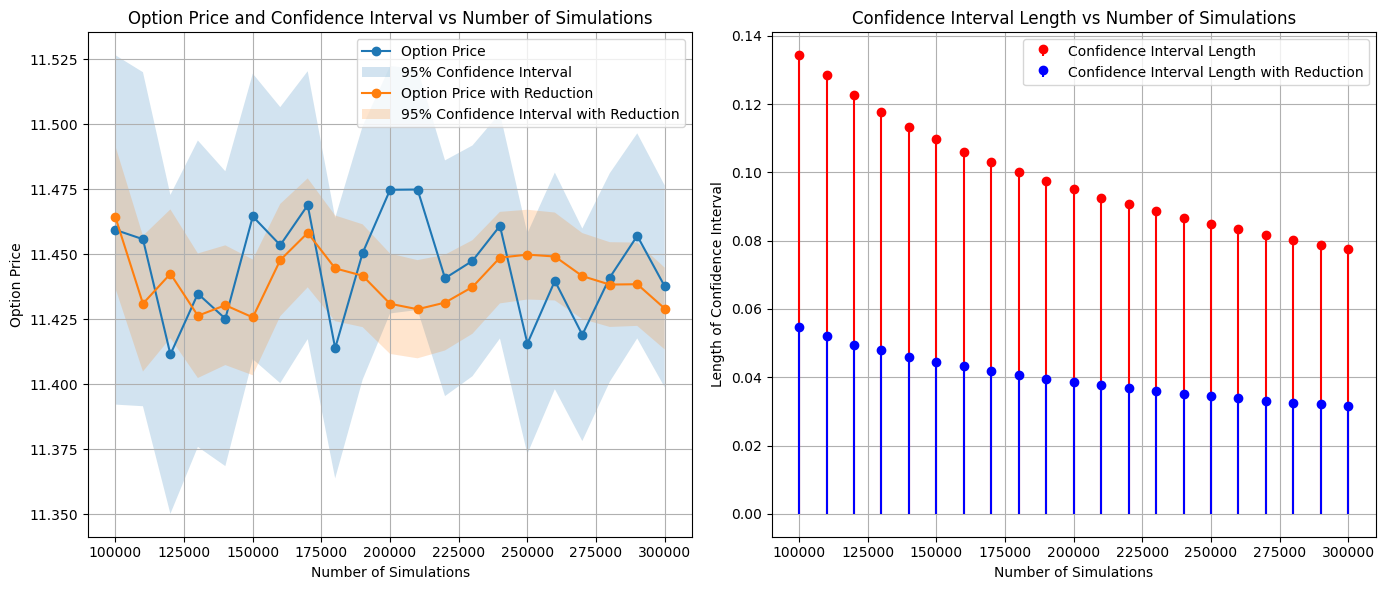

In [6]:
M_values = np.arange(100000, 301000, 10000)
prices = np.zeros(len(M_values))
interval_up = np.zeros(len(M_values))
interval_down = np.zeros(len(M_values))
prices_red = np.zeros(len(M_values))
interval_up_red = np.zeros(len(M_values))
interval_down_red = np.zeros(len(M_values))
S0=inputs['S0'] 
V0=inputs['V0']
r=inputs['r'] 
sigma=inputs['sigma'] 
a=inputs['a'] 
b=inputs['b'] 
alpha=inputs['alpha']
rho=inputs['rho']
T=inputs['T'] 
K=inputs['K'] 
n=int(inputs['n']) 
for i in range (len(M_values)):
    
    M=M_values[i]
    prices[i], interval_down[i], interval_up[i] = HWcall_MC(S0, V0, r, sigma, a, b, alpha, rho, T, K, n, M, red = 1)
    prices_red[i], interval_down_red[i], interval_up_red[i] = HWcall_MC(S0, V0, r, sigma, a, b, alpha, rho, T, K, n, M, red = 0)

conf_lengths = interval_up-interval_down
conf_lengths_red = interval_up_red-interval_down_red
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
# Wykres 1: Wartość opcji i przedziały ufności
ax[0].plot(M_values, prices, label='Option Price', marker='o')
ax[0].fill_between(M_values, interval_up, interval_down, alpha=0.2, label='95% Confidence Interval')
ax[0].plot(M_values, prices_red, label='Option Price with Reduction', marker='o')
ax[0].fill_between(M_values, interval_up_red, interval_down_red, alpha=0.2, label='95% Confidence Interval with Reduction')
ax[0].set_title('Option Price and Confidence Interval vs Number of Simulations')
ax[0].set_xlabel('Number of Simulations')
ax[0].set_ylabel('Option Price')
ax[0].legend()
ax[0].grid(True)

# Wykres 2: Długości przedziałów ufności
ax[1].stem(M_values, conf_lengths, label='Confidence Interval Length', linefmt='r-', markerfmt='ro', basefmt=' ')
ax[1].stem(M_values, conf_lengths_red, label='Confidence Interval Length with Reduction', linefmt='b-', markerfmt='bo', basefmt=' ')
ax[1].set_title('Confidence Interval Length vs Number of Simulations')
ax[1].set_xlabel('Number of Simulations')
ax[1].set_ylabel('Length of Confidence Interval')
ax[1].legend(loc='upper right')
ax[1].grid(True)

plt.tight_layout()
plt.show()

In [7]:
inputs_test = read_inputs("cp3_test_data.txt")

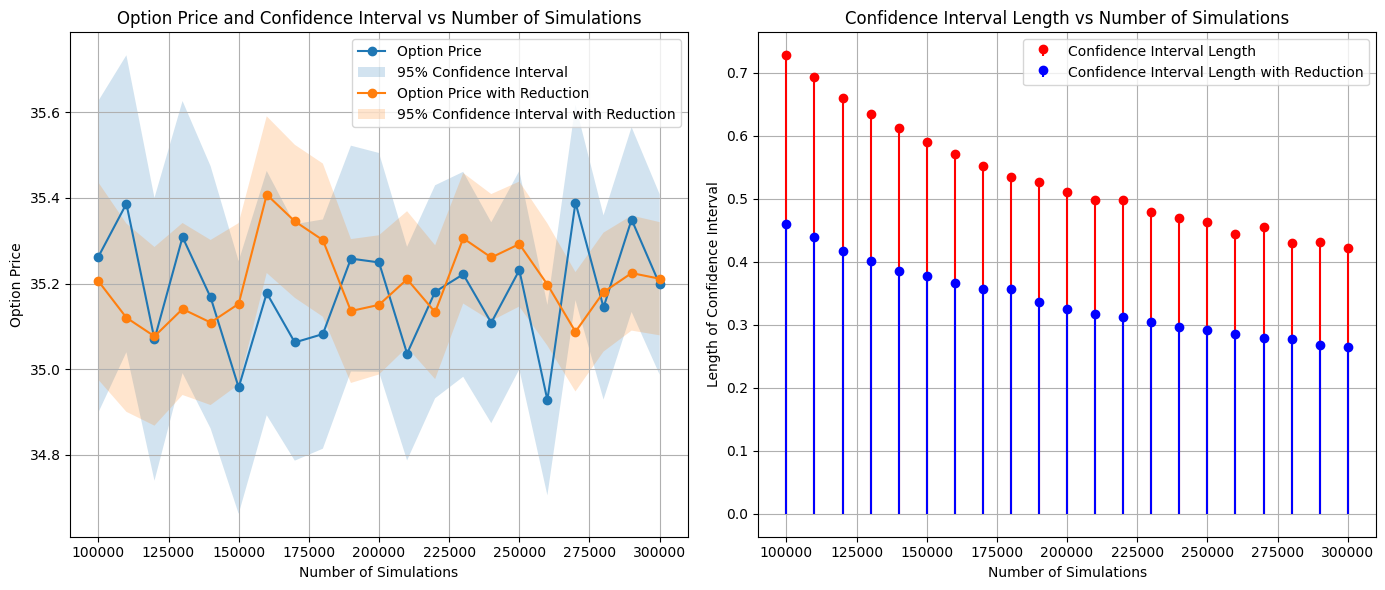

In [9]:
M_values = np.arange(100000, 301000, 10000)
prices = np.zeros(len(M_values))
interval_up = np.zeros(len(M_values))
interval_down = np.zeros(len(M_values))
prices_red = np.zeros(len(M_values))
interval_up_red = np.zeros(len(M_values))
interval_down_red = np.zeros(len(M_values))
S0=inputs_test['S0'] 
V0=inputs_test['V0']
r=inputs_test['r'] 
sigma=inputs_test['sigma'] 
a=inputs_test['a'] 
b=inputs_test['b'] 
alpha=inputs_test['alpha']
rho=inputs_test['rho']
T=inputs_test['T'] 
K=inputs_test['K'] 
n=int(inputs_test['n']) 
for i in range (len(M_values)):
    
    M=M_values[i]
    prices[i], interval_down[i], interval_up[i] = HWcall_MC(S0, V0, r, sigma, a, b, alpha, rho, T, K, n, M, red = 1)
    prices_red[i], interval_down_red[i], interval_up_red[i] = HWcall_MC(S0, V0, r, sigma, a, b, alpha, rho, T, K, n, M, red = 0)

conf_lengths = interval_up-interval_down
conf_lengths_red = interval_up_red-interval_down_red
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
# Wykres 1: Wartość opcji i przedziały ufności
ax[0].plot(M_values, prices, label='Option Price', marker='o')
ax[0].fill_between(M_values, interval_up, interval_down, alpha=0.2, label='95% Confidence Interval')
ax[0].plot(M_values, prices_red, label='Option Price with Reduction', marker='o')
ax[0].fill_between(M_values, interval_up_red, interval_down_red, alpha=0.2, label='95% Confidence Interval with Reduction')
ax[0].set_title('Option Price and Confidence Interval vs Number of Simulations')
ax[0].set_xlabel('Number of Simulations')
ax[0].set_ylabel('Option Price')
ax[0].legend()
ax[0].grid(True)

# Wykres 2: Długości przedziałów ufności
ax[1].stem(M_values, conf_lengths, label='Confidence Interval Length', linefmt='r-', markerfmt='ro', basefmt=' ')
ax[1].stem(M_values, conf_lengths_red, label='Confidence Interval Length with Reduction', linefmt='b-', markerfmt='bo', basefmt=' ')
ax[1].set_title('Confidence Interval Length vs Number of Simulations')
ax[1].set_xlabel('Number of Simulations')
ax[1].set_ylabel('Length of Confidence Interval')
ax[1].legend(loc='upper right')
ax[1].grid(True)

plt.tight_layout()
plt.show()